### Load KITTI Dataset in Python

In [17]:
import pykitti

# Correct base directory (should point to "dataset/")
basedir = "/home/deepak-bhagat/Downloads/data_odometry_velodyne/dataset/"

# Only specify sequence number
sequence = "00"  # Test sequence 00

# Load KITTI odometry dataset
dataset = pykitti.odometry(basedir, sequence)

# Check the number of frames
print(f"Loaded {len(dataset.timestamps)} frames from sequence {sequence}")


Loaded 4541 frames from sequence 00


### Visualize LiDAR Data

In [18]:
import open3d as o3d
import numpy as np

# Load the first LiDAR frame (frame 0)
scan = dataset.get_velo(0)

# Convert to Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(scan[:, :3])  # Use x, y, z coordinates

# Visualize the LiDAR point cloud
o3d.visualization.draw_geometries([pcd])

# import open3d as o3d
# import numpy as np
# import time

# # Load all LiDAR frames from KITTI sequence 00
# num_frames = len(dataset.timestamps)  # Total frames
# vis = o3d.visualization.Visualizer()
# vis.create_window()

# pcd = o3d.geometry.PointCloud()

# for i in range(num_frames):  # Loop through all frames
#     scan = dataset.get_velo(i)  # Load LiDAR frame
#     pcd.points = o3d.utility.Vector3dVector(scan[:, :3])  # Convert to Open3D format

#     if i == 0:
#         vis.add_geometry(pcd)
#     else:
#         vis.update_geometry(pcd)

#     vis.poll_events()
#     vis.update_renderer()
#     time.sleep(0.05)  # Adjust speed of animation

# vis.destroy_window()



### Implement Basic ICP SLAM

# ICP-based SLAM Explanation

## What This Code Does

- Loads **two LiDAR scans** (`pcd1` and `pcd2`).
- Uses **Iterative Closest Point (ICP)** to align `pcd2` to `pcd1`.
- Computes a **transformation matrix** that represents how `pcd2` should be moved to match `pcd1`.

## Transformation Matrix

The transformation matrix output looks like this:

\[
\begin{bmatrix} 
R_{11} & R_{12} & R_{13} & t_x \\ 
R_{21} & R_{22} & R_{23} & t_y \\ 
R_{31} & R_{32} & R_{33} & t_z \\ 
0 & 0 & 0 & 1 
\end{bmatrix}
\]

Where:
- **R** represents **rotation** (how the scan is rotated).
- **t** represents **translation** (how the scan is shifted).

## Why This is Useful

This matrix updates the robot’s **position** and **map**, helping it track movement over time. 🚀


Processing Frames: 100%|██████████| 4540/4540 [06:46<00:00, 11.17it/s]


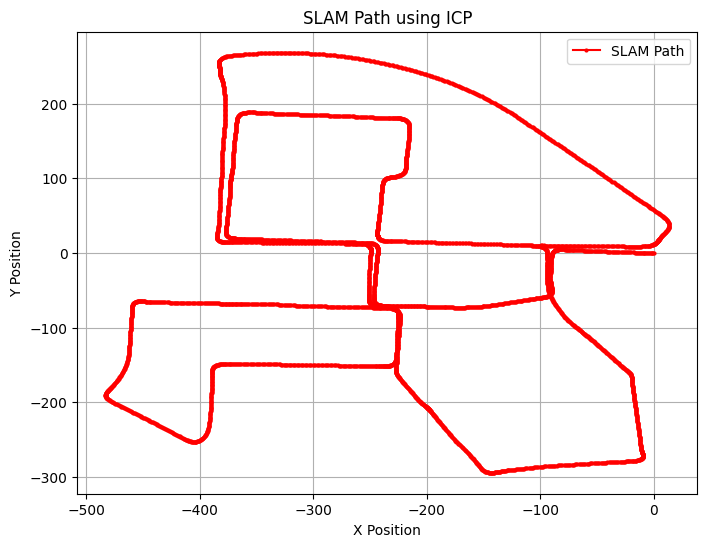

In [32]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # Progress bar

# Load dataset (Ensure dataset is correctly loaded)
# dataset = ... (Define your dataset here)

def icp_slam(source, target, threshold=0.5):
    """Applies Iterative Closest Point (ICP) for SLAM with preprocessing"""
    
    # Downsample for faster processing
    source = source.voxel_down_sample(voxel_size=0.3)
    target = target.voxel_down_sample(voxel_size=0.3)

    # Estimate normals for better alignment
    target.estimate_normals(o3d.geometry.KDTreeSearchParamHybrid(radius=1.0, max_nn=30))

    # Apply ICP
    icp = o3d.pipelines.registration.registration_icp(
        source, target, threshold, np.eye(4),
        o3d.pipelines.registration.TransformationEstimationPointToPlane(),
        o3d.pipelines.registration.ICPConvergenceCriteria(max_iteration=50)
    )
    
    # Reject outlier transformations
    translation = np.linalg.norm(icp.transformation[:3, 3])
    if translation > 1.5:  # Adjust threshold for better accuracy
        print("Warning: Large transformation detected, skipping frame")
        return np.eye(4)
    
    return icp.transformation


# Initialize trajectory
trajectory = [np.eye(4)]  # Start at origin

# Load first frame
pcd1 = o3d.geometry.PointCloud()
pcd1.points = o3d.utility.Vector3dVector(dataset.get_velo(0)[:, :3])

num_frames = 4541  # Set dynamically based on dataset

# Use tqdm for progress tracking
for i in tqdm(range(1, num_frames), desc="Processing Frames"):
    pcd2 = o3d.geometry.PointCloud()
    pcd2.points = o3d.utility.Vector3dVector(dataset.get_velo(i)[:, :3])

    transformation = icp_slam(pcd1, pcd2)

    trajectory.append(trajectory[-1] @ transformation)
    
    pcd1 = pcd2  # Move to next frame

# Convert trajectory to numpy array
trajectory = np.array(trajectory)[:, :3, 3]  # Extract x, y positions

# Plot trajectory
plt.figure(figsize=(8, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], 'ro-', markersize=2, label="SLAM Path")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("SLAM Path using ICP")
plt.legend()
plt.grid()
plt.show()


/tmp/ipykernel_1538699/235943889.py:46: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', marker='o', linestyle='-', label='SLAM Path')


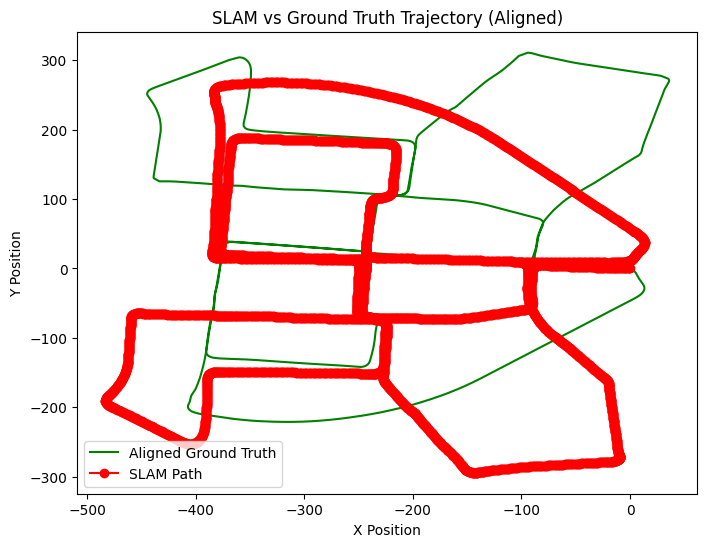

In [50]:
import numpy as np
import matplotlib.pyplot as plt

def rotate_trajectory(points, angle):
    """
    Rotates the given trajectory by a specified angle.

    Parameters:
        points (numpy.ndarray): (N, 2) array of (x, y) coordinates.
        angle (float): Rotation angle in radians.

    Returns:
        numpy.ndarray: Rotated trajectory.
    """
    R = np.array([[np.cos(angle), -np.sin(angle)], 
                  [np.sin(angle), np.cos(angle)]])
    return points @ R.T  # Apply rotation

# Load Ground Truth Poses
gt_poses = np.loadtxt("/home/deepak-bhagat/Downloads/data_odometry_velodyne/dataset/poses/00.txt")
gt_poses = gt_poses.reshape(-1, 3, 4)

# Extract Ground Truth Trajectory (X and Y coordinates only)
gt_x = gt_poses[:, 0, 3]  
gt_y = gt_poses[:, 2, 3]  
gt_trajectory = np.vstack((gt_x, gt_y)).T  # Shape (N, 2)

# Ensure SLAM trajectory is available
trajectory = np.array(trajectory)  # Convert to NumPy array
trajectory = trajectory[:, :2]  # Keep only (x, y) coordinates

# Compute Optimal Rotation Angle
angle = np.arctan2(trajectory[-1, 1] - trajectory[0, 1], trajectory[-1, 0] - trajectory[0, 0]) - \
        np.arctan2(gt_trajectory[-1, 1] - gt_trajectory[0, 1], gt_trajectory[-1, 0] - gt_trajectory[0, 0])

# Rotate Ground Truth Trajectory
rotated_gt_trajectory = rotate_trajectory(gt_trajectory, angle)

# Translate to Match SLAM Starting Point
translation = trajectory[0] - rotated_gt_trajectory[0]  # Ensure both have shape (2,)
rotated_gt_trajectory += translation  # Apply translation

# Plot the results
plt.figure(figsize=(8, 6))
plt.plot(rotated_gt_trajectory[:, 0], rotated_gt_trajectory[:, 1], 'g-', label='Aligned Ground Truth')
plt.plot(trajectory[:, 0], trajectory[:, 1], 'r-', marker='o', linestyle='-', label='SLAM Path')

plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.legend()
plt.title("SLAM vs Ground Truth Trajectory (Aligned)")
plt.show()


### Implement A Path Planning*

In [21]:
import heapq

def astar(grid, start, goal):
    """A* Algorithm for Path Planning"""
    rows, cols = len(grid), len(grid[0])
    heap = [(0, start)]
    came_from = {start: None}
    cost_so_far = {start: 0}

    while heap:
        _, current = heapq.heappop(heap)
        if current == goal:
            break
        for dx, dy in [(0,1), (1,0), (0,-1), (-1,0)]:
            next_node = (current[0] + dx, current[1] + dy)
            if 0 <= next_node[0] < rows and 0 <= next_node[1] < cols:
                new_cost = cost_so_far[current] + 1
                if next_node not in cost_so_far or new_cost < cost_so_far[next_node]:
                    cost_so_far[next_node] = new_cost
                    priority = new_cost
                    heapq.heappush(heap, (priority, next_node))
                    came_from[next_node] = current
    return came_from

# Example grid-based path planning
grid = [[0]*10 for _ in range(10)]  # 10x10 empty grid
start, goal = (0, 0), (9, 9)
path = astar(grid, start, goal)
print("Path found:", path)

Path found: {(0, 0): None, (0, 1): (0, 0), (1, 0): (0, 0), (0, 2): (0, 1), (1, 1): (0, 1), (2, 0): (1, 0), (0, 3): (0, 2), (1, 2): (0, 2), (2, 1): (1, 1), (3, 0): (2, 0), (0, 4): (0, 3), (1, 3): (0, 3), (2, 2): (1, 2), (3, 1): (2, 1), (4, 0): (3, 0), (0, 5): (0, 4), (1, 4): (0, 4), (2, 3): (1, 3), (3, 2): (2, 2), (4, 1): (3, 1), (5, 0): (4, 0), (0, 6): (0, 5), (1, 5): (0, 5), (2, 4): (1, 4), (3, 3): (2, 3), (4, 2): (3, 2), (5, 1): (4, 1), (6, 0): (5, 0), (0, 7): (0, 6), (1, 6): (0, 6), (2, 5): (1, 5), (3, 4): (2, 4), (4, 3): (3, 3), (5, 2): (4, 2), (6, 1): (5, 1), (7, 0): (6, 0), (0, 8): (0, 7), (1, 7): (0, 7), (2, 6): (1, 6), (3, 5): (2, 5), (4, 4): (3, 4), (5, 3): (4, 3), (6, 2): (5, 2), (7, 1): (6, 1), (8, 0): (7, 0), (0, 9): (0, 8), (1, 8): (0, 8), (2, 7): (1, 7), (3, 6): (2, 6), (4, 5): (3, 5), (5, 4): (4, 4), (6, 3): (5, 3), (7, 2): (6, 2), (8, 1): (7, 1), (9, 0): (8, 0), (1, 9): (0, 9), (2, 8): (1, 8), (3, 7): (2, 7), (4, 6): (3, 6), (5, 5): (4, 5), (6, 4): (5, 4), (7, 3): (6, 3

### Visualize and Evaluate Results


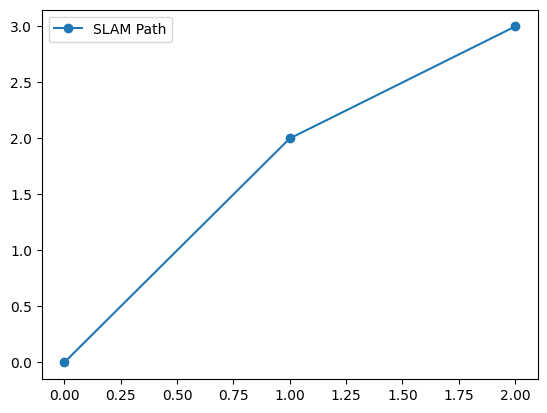

In [22]:
import matplotlib.pyplot as plt

trajectory = np.array([[0, 0], [1, 2], [2, 3]])  # Example trajectory
plt.plot(trajectory[:, 0], trajectory[:, 1], marker="o", label="SLAM Path")
plt.legend()
plt.show()